In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

## Вариант 9

### Зададим все ПФ системы исходя из схемы

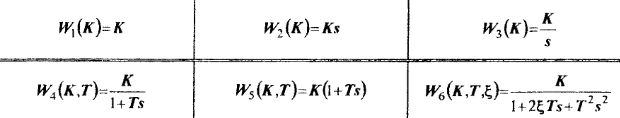
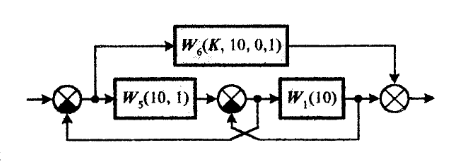

### Напишем W6, W5, W1

In [2]:
def w1() -> int:
    return 10

def w5(s: float) -> float:
    return 10*(1+s)

def w6(k: float, s: float) -> float:
    return k / (1 + 2*10*0.1*s + 10**2*s**2)


### Напишем ПФ разомкнутой системы

Наша передаточная функция будет выглядеть вот так: 

$$Wр(s) = \frac{W_5(s) \bullet W_1(s) + W_6(s)}{1 + W_5(s) + W_1(s)}$$

In [3]:
def transfer_func_open(k: float, s: float) -> float:
    numerator = w5(s)*w1() + w6(k, s)
    denominator = 1 + w5(s) + w1()
    return numerator / denominator

### Зададим входное воздействие
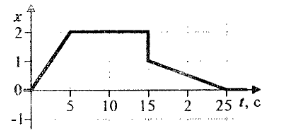

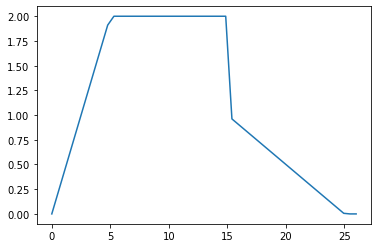

In [111]:
def x(t: float) -> float:
    if 0 <= t <= 5:
        return 0.4*t
    elif 5 <= t <= 15:
        return 2.
    elif 15 <= t <= 25:
        return -0.1*(t-25)
    elif t > 25:
        return 0.

    
def get_x_values(t: np.ndarray) -> list:
    return [x(t_value) for t_value in t]

# убедимся в том, что мы правильно задали функцию
t = np.linspace(0, 26)
plt.plot(t, get_x_values(t))

### Построение ЛАХ и ФЧХ системы

In [5]:
from ipywidgets import interact, IntSlider, FloatSlider


def convert_to_log_coordinate(freq: float) -> float:
    return 20*np.log10(np.abs(freq))


def plot_specifications(k: float):
    # частота по оси X
    omega = np.logspace(-3, 1, 100)

    # ЛАХ и ФЧХ
    lah = convert_to_log_coordinate(transfer_func_open(k, 1j * omega))
    pfr = np.angle(transfer_func_open(k, 1j * omega), deg=True)
    
    # Построение графиков друг под другом
    
    fig = plt.figure()
    
    # Построение ЛАХ
    lah_plot = fig.add_subplot(2, 1, 1)
    lah_plot.plot(np.log10(omega), lah)
    lah_plot.grid()

    # Построение ФЧХ и линии y=-180(для определения устойчивости)
    pfr_plot = fig.add_subplot(2, 1, 2)
    pfr_plot.axis(ymin=-190, ymax=10)
    pfr_plot.plot(np.log10(omega), pfr)
    pfr_plot.plot(np.log10(omega), len(np.log10(omega))*[-180], '--')
    pfr_plot.grid()


# интерактивный график для подбора коэффициента k
interact(plot_specifications, k=IntSlider(value=350, min=-500, max=500))


interactive(children=(IntSlider(value=350, description='k', max=500, min=-500), Output()), _dom_classes=('widg…

<function __main__.plot_specifications(k: float)>

**Из графиков выше можно сделать вывод, что система будет устойчивой, при K=350**

In [6]:
k = 350

#### Для тех, кто смотрит это с GitHub

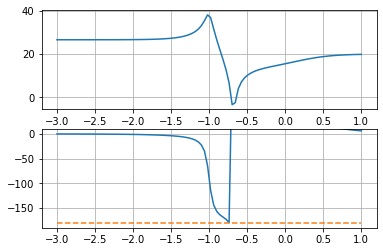

In [7]:
plot_specifications(k)

### Зададим ПФ замкнутой системы

Замкнутая система - это система разомкнутая, с еденичной обратной связью. Следовательно:

$$W_з(s) = \frac{W_р(s)}{1 + W_р(s)}$$

In [8]:
def transfer_func_close(k: float, s: float) -> float:
    open_tf = transfer_func_open(k, s)
    return open_tf / (1 + open_tf)

### Представим ПФ в форме дифференциальных уравнений

#### Для начала мы преобразуем нашу ПФ, чтобы с ней было легче работать
1. Преобразуем ПФ разомкнутой системы к математическому виду

$$W_р(s) = \frac{W_5(s) \bullet W_1(s) + W_6(s)}{1 + W_5(s) + W_1(s)} = \frac{10^4s^3 + 10200s^2 + 300s + 100 + k}{10^3s^3 + 2120s^2 + 52s + 21}$$

2. Преобразуем ПФ замкнутой системы к математическому виду

$$W_з(s) = \frac{W_р(s)}{1 + W_р(s)} = \frac{10^4s^3 + 10200s^2 + 300s + 100 + k}{11 \bullet 10^3s^3 + 12320s^2 + 352s + 121 + k}$$

#### Найдём матрицы A, B, C и D

In [195]:
# Числитель и знаменатель нашей ПФ
num = [10**4, 10200, 300, 100+k]
den = [11*10**3, 12320, 352, 121+k]

In [196]:
# перед запуском этого кода необходимо открыть на компьютере Anaconda Prompt и ввести команду:
# conda install -c conda-forge control
import control

state_matrix = control.tf2ss(num, den)
print(state_matrix)

A = [[-1.12000000e+00  3.20000000e-02  4.28181818e-01]
     [-1.00000000e+00  3.97725245e-17 -3.76314641e-17]
     [ 0.00000000e+00  1.00000000e-01  9.71445147e-17]]

B = [[-1.]
     [ 0.]
     [ 0.]]

C = [[ 0.09090909 -0.00181818  0.01983471]]

D = [[0.90909091]]



### Зададим уравнения системы и построим переходной процесс

Из матриц A, B, C и D получим систему
$$
\begin{cases}
    \dot Z = A \bullet Z + B \bullet U  \\
    Y = C \bullet Z + D \bullet U \\
\end{cases}
$$

In [197]:
# Ось X - время
t = np.linspace(0, 26, 101)

#### Зададим дифф. форму сигнала Z

In [201]:
def get_diff_form_z(z, t, u, state_matrix):
    # Z' = AZ + BU
    new_dim_z = np.expand_dims(z, axis=-1)
    zs = np.dot(state_matrix.A, new_dim_z) + state_matrix.B*u(t)
    return np.squeeze(zs)

#### Зададим выходной сигнал Y

In [200]:
def get_output_signal(t: np.ndarray):
    # Y = CZ + DU
    z = odeint(get_diff_form_z, np.zeros(3), t, args=(x, state_matrix,))
    y = np.dot(state_matrix.C, np.transpose(z)) + state_matrix.D * get_x_values(t)
    return y[0, :]

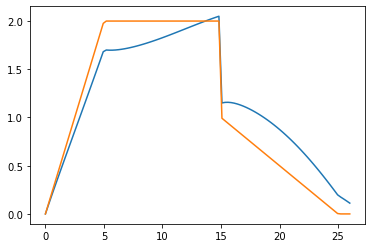

In [202]:
plt.plot(t, get_output_signal(t))
plt.plot(t, get_x_values(t))

#### Зададим функцию ошибки

In [205]:
def get_error(t: np.ndarray):
    return get_x_values(t) - get_output_signal(t)

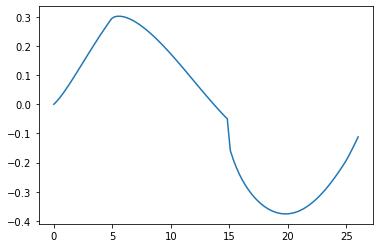

In [206]:
plt.plot(t, get_error(t))

### Напишем функцию IV из мизрахички и проверим её работу на сигнале *err*

In [173]:
def iv(err, t, tau):
    de_dt = np.diff(err)/(t[1]-t[0])
    return np.sum(err**2) + tau**2 * np.sum(de_dt**2)

In [207]:
# это коэфф рассчитывается по частоте среза вашего ЛАХа, я уже забыл формулу, но у меня он 74 :)
tau = 74
iv(get_error(t), t, tau)

2287.967140591368

### Посчитаем новый коэффициент K по функции минимизации

#### Для этого нам надо задать целевую функцию

In [213]:
def transient(k, x):
    num = [10**4, 10200, 300, 100+k[0]]
    den = [11*10**3, 12320, 352, 121+k[0]]
    
    state_matrix = control.tf2ss(num, den)
    
    z = odeint(get_diff_form_z, np.zeros(3), t, args=(x, state_matrix,))
    y = np.dot(state_matrix.C, np.transpose(z)) + state_matrix.D * get_x_values(t)
    return y[0, :]

def target_func(k, x):
    Y = transient(k, x)
    err = get_x_values(t) - Y
    return iv(err, t, tau)

In [214]:
from scipy.optimize import minimize

res = minimize(target_func, (350), args = (x,), method='SLSQP', bounds=((100, 400),))
print(res)

     fun: 2286.992032666571
     jac: array([-1278.22845459])
 message: 'Optimization terminated successfully'
    nfev: 32
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([349.75488841])


#### Мы посчитали новый k и она равен 349.75488841

In [194]:
new_k = res.x[0]
new_k

349.7548884120902

#### Построим переходной процесс

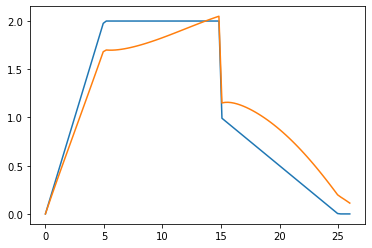

In [216]:
plt.plot(t, get_x_values(t))
plt.plot(t, transient([new_k], x))

## Вывод

В этой практической работе, я подобрал коэффиент системы по графикам ЛАХ и ФЧХ, а потом применил функцию минимизации для определения коэффицента алгоритмическим путём.